# 12.3 Named Entity Recognition using Bi-LSTM

개체명 인식은 챗봇 등에서 필요로 하는 주요 전처리 작업이지만, 그 자체로도 까다로운 작업이기도 합니다. 도메인 또는 목적에 특화되도록 개체명 인식을 정확하게 하는 방법 중 하나는 기존에 공개된 개체명 인식기를 사용하는 것이 아니라, 직접 목적에 맞는 데이터를 준비하여 기계를 훈련시켜 모델을 만드는 방법입니다. 여기서는 양방향 LSTM을 이용해서 개체명 인식기를 만들어봅니다.

### 1. BIO 표현
---
개체명 인식에서 코퍼스로부터 개체명을 인식하기 위한 방법으로는 여러 방법이 있지만, 여기서는 가장 보편적인 방법 중 하나인 IOB (또는 BIO) 방법을 소개합니다. B는 Begin의 약자로 개체명이 시작되는 부분, I는 Inside의 약자로 개체명의 내부 부분을 의미하며, O는 Outside의 약자로 개체명이 아닌 부분을 의미합니다.

예를 들어서 영화에 대한 코퍼스 중에서 영화 제목에 대한 개체명을 뽑아내고 싶다고 가정합시다
>
>해 B  
리 I  
포 I  
터 I  
보 O  
러 O  
가 O  
자 O  

다음과 같이 영화 제목에 대해서만 개체명을 인식하는데, 영화 제목이 시작되는 글자인 '해'에서는 B가 사용되었고, 그리고 영화 제목이 끝나는 순간까지 I가 사용됩니다. 그리고 영화 제목이 아닌 부분에 대해서만 O가 사용됩니다. 이처럼 B와 I는 개체명을 위해 사용되고, O는 개체명이 아니라는 의미를 갖게 됩니다.

물론 개체명 인식이라는 것은 보통 한 종류의 개체에 대해서만 언급하는 것이 아니라, 여러 종류의 개체가 있을 수 있습니다. 예를 들어 영화에 대한 대화에서는 영화 제목에 대한 개체명과 극장에 대한 개체명이 있을 수 있습니다. 그럴 때는, 각 개체가 어떤 종류인지도 함께 태깅이 될 것입니다

>해 B-movie  
리 I-movie  
포 I-movie  
터 I-movie  
보 O  
러 O  
메 B-theater  
가 I-theater  
박 I-theater  
스 I-theater  
가 O  
자 O  


### 2. 개체명 인식 데이터 이해하기
---
이제 실습을 통해 양방향 LSTM을 이용한 개체명 인식에 대해서 더 자세히 알아보도록 하겠습니다. CONLL2003은 개체명 인식을 위한 전통적인 영어 데이터 셋입니다. 해당 데이터를 가지고 훈련하여 개체명 인식 모델을 만들어보겠습니다.

다운로드 링크 : https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt
전체 데이터는 위 링크에서 train.txt 파일을 다운로드 받을 수 있습니다.
```
EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER
```

해당 데이터의 앞 부분을 일부 보겠습니다.

해당 데이터의 양식은 [단어] [품사 태깅] [청크 태깅] [개체명 태깅]의 형식으로 되어있습니다.

품사 태깅이 의미하는 바는 아래 링크에서 자세하게 확인할 수 있는데, 예를 들어서 EU 옆에 붙어있는 NNP는 고유 명사 단수형을 의미하며, rejects 옆에 있는 VBZ는 3인칭 단수 동사 현재형을 의미합니다.
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

개체명 태깅의 경우에는 LOC는 location, ORG는 organization, PER은 person, MISC는 miscellaneous를 의미합니다. 해당 데이터는 BIO 표현 방법을 사용하고 있기 때문에, 개체명의 시작 부분이면서 Organization을 의미하는 German에는 B-ORG라는 개체명 태깅이 붙습니다. 다만, German 그 자체로 개체명 하나이기 때문에 거기서 개체명 인식은 종료되면서 뒤에 I가 별도로 붙는 단어가 나오지는 않았습니다. 이에 German 뒤에 나오는 call은 개체명이 아니기 때문에 O가 태깅이 됩니다.

또 하나 기억해두어야할 것은 9번째 줄인. . O O 다음에 11번째 줄 Peter가 나오는 부분 사이에서 10번째 줄은 공란으로 되어 있는데, 이는 9번째 줄에서 문장이 끝나고 11번째 줄에서 새로운 문장이 시작됨을 의미합니다.

그 다음 문장이 시작되는 11번째 줄에서는 개체명이 하나의 단어로 끝나지 않았을 때, 어떻게 다음 단어로 개체명 인식이 이어지는지를 보여줍니다. Peter는 개체명이 시작되면서 person에 해당되기 때문에 B-PER이라는 개체명 태깅이 붙습니다. 그리고 아직 개체명에 대한 인식은 끝나지 않았기 때문에 뒤에 붙는 Blackburn에서는 I가 나오면서 I-PER이 개체명 태깅으로 붙게 됩니다. 즉, Peter Blackburn이 person에 속하는 하나의 개체명입니다

### 3. 데이터 전처리하기
이번에는 양방향 LSTM을 이용해서 개체명 인식 태깅을 하는 모델을 만들어보겠습니다.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
with open('../../data/train.txt', 'r') as f:
    tagged_sentences =[]
    sentence = []
    
    for line in f:
        if len(line) ==0 or line.startswith('-DOCSTART') or line[0] == '\n':
            if len(sentence) > 0:
                tagged_sentences.append(sentence)
                sentence =[]
            continue
        splits = line.split(' ')
        splits[-1] = re.sub(r'\n', '', splits[-1])
        word = splits[0].lower()
        sentence.append([word, splits[-1]])

In [3]:
print('Total samples count : ', len(tagged_sentences))
print(tagged_sentences[0])

Total samples count :  14041
[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


전처리가 수행된 첫번째 샘플이 출력된 것을 볼 수 있습니다. 이러한 샘플이 총 14,041개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('eu', 'B-ORG'), ('rejects', 'O')]와 같은 문장 샘플이 있다면 eu와 rejects는 같이 저장하고, B-ORG와 O를 같이 저장할 필요가 있습니다.

이런 경우 파이썬 함수 중에서 zip()함수가 유용한 역할을 합니다. zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다. (2챕터의 데이터의 분리 챕터 참고)

In [4]:
sentences, ner_tags =[],[]

for tagged_sentence in tagged_sentences:
    sentence , tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

In [5]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서만 sentences[0]에, 또한 개체명에 대해서만 ner_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 ner_tags는 예측 대상인 y에 해당됩니다. 다른 샘플들에 대해서도 처리가 되었는지 확인하기 위해 임의로 13번째 샘플에 대해서도 확인해보겠습니다.

In [6]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


단어에 대해서만 sentences[12]에, 또한 개체명에 대해서만 ner_tags[12]에 저장된 것을 확인할 수 있습니다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있습니다. 사실 14,041개의 문장 샘플의 길이는 전부 제각각입니다. 전체 데이터의 길이 분포를 확인해봅시다.

샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


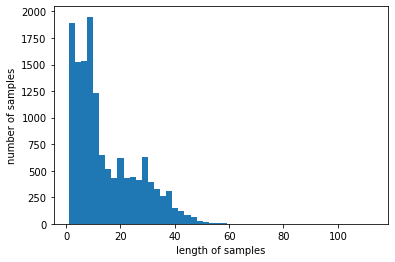

In [7]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 샘플들의 길이가 대체적으로 0~40의 길이를 가지며, 특히 0~20의 길이를 가진 샘플이 상당한 비율을 차지하는 것을 보여줍니다. 길이가 가장 긴 샘플의 길이는 113입니다. 이제 케라스 토크나이저를 통해서 토큰화와 정수 인코딩을 진행합니다. 이번에는 문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4,000개의 단어만을 사용합니다.

In [8]:
max_words = 4000
src_tokenizer = Tokenizer(num_words =max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [10]:
vc_size = max_words
tag_size = len(tar_tokenizer.word_index)+1
print('단어 집합의 크기 : {}'.format(vc_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


이제 정수 인코딩을 수행합니다.

In [11]:
x_train=src_tokenizer.texts_to_sequences(sentences)
y_train=tar_tokenizer.texts_to_sequences(ner_tags)

In [12]:
print(x_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


현재 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체된 상황입니다. 이를 확인하기 위해 다시 디코딩(정수에서 다시 텍스트 데이터로 변환) 작업을 해보겠습니다. 이를 위해 인덱스로부터 단어를 리턴하는 index_to_word를 만듭니다.

In [13]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

정수 인코딩 된 첫번째 문장을 다시 디코딩해보겠습니다.

In [14]:
decoded =[]

for index in x_train[0]:
    decoded.append(index_to_word[index])

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


앞서 본 그래프에 따르면, 대부분의 샘플은 길이가 70 이내입니다. X에 해당되는 데이터 X_train의 샘플들과 y에 해당되는 데이터 y_train 샘플들의 모든 길이를 임의로 70정도로 맞추어 보겠습니다. 이를 위해서 케라스의 pad_sequences()를 사용합니다.

In [15]:
max_len = 70

x_train = pad_sequences(x_train, maxlen = max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = max_len, padding='post')

In [16]:
x_train, x_test, y_train,y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=777)

레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행합니다.

In [17]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [18]:
print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


### 4. 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vc_size , output_dim=128,  input_length=max_len, mask_zero =True))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

- **Many-to-Many** 문제이므로 LSTM()에 **return_sequences=True**를 설정해준 것을 볼 수 있습니다. 
- 또한, 이번 실습과 같이 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정하여 데이터에서 숫자 0은 패딩을 의미하므로 연산에서 제외시킨다는 옵션을 줄 수 있습니다.

In [22]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(x_train,  y_train, batch_size=128,epochs=8,validation_data=(x_test,y_test))

Train on 11232 samples, validate on 2809 samples
Epoch 1/8
11232/11232 [==============================] - 194s 17ms/sample - loss: 0.1895 - accuracy: 0.8239 - val_loss: 0.1287 - val_accuracy: 0.8328
Epoch 2/8
11232/11232 [==============================] - 194s 17ms/sample - loss: 0.1011 - accuracy: 0.8534 - val_loss: 0.0772 - val_accuracy: 0.8834
Epoch 3/8
11232/11232 [==============================] - 207s 18ms/sample - loss: 0.0654 - accuracy: 0.9052 - val_loss: 0.0529 - val_accuracy: 0.9242
Epoch 4/8
11232/11232 [==============================] - 206s 18ms/sample - loss: 0.0458 - accuracy: 0.9353 - val_loss: 0.0404 - val_accuracy: 0.9435
Epoch 5/8
11232/11232 [==============================] - 207s 18ms/sample - loss: 0.0352 - accuracy: 0.9505 - val_loss: 0.0356 - val_accuracy: 0.9508
Epoch 6/8
11232/11232 [==============================] - 196s 17ms/sample - loss: 0.0289 - accuracy: 0.9586 - val_loss: 0.0323 - val_accuracy: 0.9556
Epoch 7/8
11232/11232 [============================

In [23]:
print('Accuracy of test : %.4f' %(model.evaluate(x_test,y_test)[1]))

2809/2809 [==============================] - 23s 8ms/sample - loss: 0.0317 - accuracy: 0.9571
Accuracy of test : 0.9571


실제로 맞추고 있는지를 테스트 데이터를 주고 직접 실제값과 비교해보도록 하겠습니다. 앞서 만들어둔 인덱스로부터 단어와 개체명 태깅 정보를 리턴하는 index_to_word와 index_to_ner를 사용하여 테스트 데이터에 대한 예측값과 실제값을 비교 출력하도록 합니다.

In [25]:
i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([x_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i],-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print('{:15}|{:5}|{}'.format('word','real value','predict value'))
print(35*'-')

for w, t, pred in zip(x_test[i],true,y_predicted[0]):
    if w !=0: # PAD값은 제외함.
        print('{:17}: {:7} {}'.format(index_to_word[w],index_to_ner[t].upper(), index_to_ner[pred].upper()))        

word           |real value|predict value
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              

정확도를 계산하고, 테스트용 샘플에 대해서 예측한 개체명도 출력해보았습니다. 출력 결과는 그럴듯해 보이지만 사실 이번에 사용한 정확도 측정 방법이 그다지 적절하지는 않았습니다. 대부분의 단어가 개체명이 아니라는 'O'가 태깅된 상황에서 예측 정확도가 수많은 'O'로 인해 결정되고 있기 때문입니다. 이를 해결하는 방법으로는 여러가지가 있겠지만, 그 중 한 가지는 F1-score를 도입하는 것입니다. 이에 대해서는 양방향 LSTM과 CRF 챕터에서 배웁니다.